In [61]:
import warnings
warnings.simplefilter("ignore")

import mhcflurry
import numpy
import seaborn
import logging
import pandas
from os import environ
from matplotlib import pyplot
from mhcflurry.downloads import get_path

% matplotlib inline

import IPython.core.display as display

In [2]:
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle(); jQuery("div.output_stderr").toggle();}});</script>', raw=True)

# MHCflurry models

## Class 1 allele specific ensemble models

This report describes the models published with MHCflurry for Class I affinity prediction. These models were trained on the "data_combined_iedb_kim2014" affinity measurement dataset (mostly from IEDB) distributed with MHCflurry.

Each allele's predictor is an ensemble of 16 models. The models were trained on a random 1/2 of the data for the allele and tested on the other half. The best performing model in terms of sum of AUC (at 500nM), F1, and Kendall Tau for each 50/50 split of the data was selected for inclusion in the ensemble.

In [66]:
all_models_df = pandas.read_csv(get_path("models_class1_allele_specific_ensemble", "all_models.csv.bz2"))
all_models_df["hyperparameters_layer_sizes"] = all_models_df["hyperparameters_layer_sizes"].map(eval)

full_training_data = mhcflurry.affinity_measurement_dataset.AffinityMeasurementDataset.from_csv(
    get_path("data_combined_iedb_kim2014", "combined_human_class1_dataset.csv"))

training_sizes = full_training_data.to_dataframe().allele.value_counts()

all_models_df["train_size"] = training_sizes.ix[all_models_df.allele].values

(ensemble_size,) = all_models_df.ensemble_size.value_counts().index
ensemble_size

selected_models_df = all_models_df.ix[all_models_df.weight > 0]
selected_models_df.shape

alleles = [x for x in training_sizes.sort_values().index if x in selected_models_df.allele.values]

In [60]:
training_sizes_for_included_alleles = training_sizes.ix[
    training_sizes.index.isin(all_models_df.allele)
]

lines = []
def row(label, value):
    lines.append('<tr><td><b>%s</b></td><td>%s</td></tr>' % (label, value))

lines.append('<h1>Models summary</h1>')
lines.append('<table>')

row("Num Alleles", "{:,d}".format(all_models_df.allele.nunique()))
row("Ensemble size", "{:,d}".format(ensemble_size))
row("Num architectures", "{:,d}".format(all_models_df.hyperparameters_architecture_num.nunique()))
row("Num selected models", "{:,d}".format((all_models_df.weight > 0).sum()))
row("Total models tested", "{:,d}".format(len(all_models_df)))
row("Total training measurements", "{:,d}".format(training_sizes_for_included_alleles.sum()))
row("Training measurement per allele",
    "min={:,g}; max={:,g}; median={:,g}".format(
        training_sizes_for_included_alleles.min(),
        training_sizes_for_included_alleles.max(),
        training_sizes_for_included_alleles.median()))


lines.append('</table>')
lines.append("<p><b>Alleles included: </b>%s</p>" % " ".join(
        training_sizes_for_included_alleles.index))


di.display_html("\n".join(lines), raw=True)

Num Alleles,132
Ensemble size,16
Num architectures,162
Num selected models,"2,112"
Total models tested,"342,144"
Total training measurements,"192,177"
Training measurement per allele,"min=26; max=12,357; median=721.5"


In [81]:
architecture_num_to_row = all_models_df.groupby("hyperparameters_architecture_num").apply(lambda df: df.iloc[0])

hyperparameters = [
    x for x in architecture_num_to_row.columns
    if x.startswith("hyperparameters_") and pandas.Series([
        str(item) for item in architecture_num_to_row[x]
    ]).nunique() > 1
]
architecture_num_to_hyperparameters = {}
for _, row in architecture_num_to_row.iterrows():
    architecture_num_to_hyperparameters[row.hyperparameters_architecture_num] = (
        row[hyperparameters].to_dict())

# Best models

This table gives the models most often selected for alleles with less than or equal to the given number of training samples.

In [100]:
result_df = []
cutoffs = [100, 500, 1000, numpy.inf]
for cutoff in cutoffs:
    selected_rates = all_models_df.ix[
        all_models_df.train_size <= cutoff
    ].groupby("hyperparameters_architecture_num").weight.mean().sort_values(ascending=False)
    best_architecture = selected_rates.index[0]
    d = dict(
        (key.replace("hyperparameters_", ""), value) for (key, value) in 
        architecture_num_to_hyperparameters[best_architecture].items())
    d["architecture selection rate (%)"] = selected_rates.ix[best_architecture] * 100
    result_df.append(d)
result_df = pandas.DataFrame(result_df, index=cutoffs)
result_df.index.name = "Training size cutoff"
result_df.T

Training size cutoff,100.0,500.0,1000.0,inf
architecture_num,112,81,112,27
best architecture selected rate (%),3.27381,2.04545,2.27273,3.64583
dropout_probability,0.1,0,0.1,0.1
embedding_output_dim,8,8,8,8
fraction_negative,0.1,0,0.1,0
impute,True,True,True,False
layer_sizes,[64],[12],[64],[12]


## Full hyperparameters of best model

In [112]:
best_hyperparameters = eval(
    architecture_num_to_row.ix[result_df.ix[numpy.inf].architecture_num].hyperparameters)
best_hyperparameters

{'activation': 'tanh',
 'architecture_num': 27,
 'batch_normalization': True,
 'batch_size': 128,
 'dropout_probability': 0.1,
 'embedding_output_dim': 8,
 'fraction_negative': 0,
 'impute': False,
 'impute_method': 'mice',
 'impute_min_observations_per_allele': 3,
 'impute_min_observations_per_peptide': 3,
 'imputer_args': {'n_burn_in': 5,
  'n_imputations': 50,
  'n_nearest_columns': 25},
 'include_ms': True,
 'init': 'glorot_uniform',
 'kmer_size': 9,
 'layer_sizes': [12],
 'loss': 'mse',
 'max_ic50': 50000.0,
 'ms_decoy_affinity': 20000.0,
 'ms_hit_affinity': 1.0,
 'n_training_epochs': 250,
 'optimizer': 'rmsprop',
 'output_activation': 'sigmoid',
 'pretrain_decay': 'numpy.exp(-epoch)'}

## Accuracy

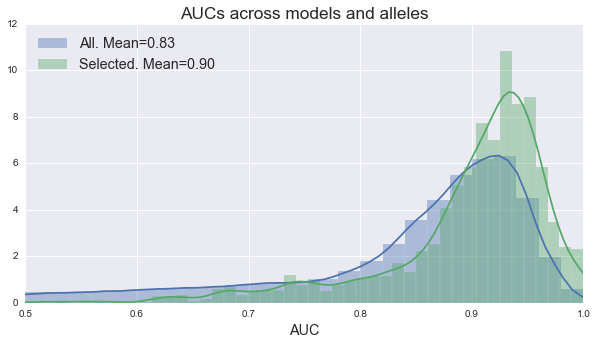

In [6]:
all_scores = all_models_df.scores_auc.dropna()
selected_scores = all_models_df.ix[all_models_df.weight > 0].scores_auc.dropna()

pyplot.figure(figsize=(10, 5))
seaborn.distplot(all_scores, label="All. Mean=%0.2f" % all_scores.mean())
seaborn.distplot(selected_scores, label="Selected. Mean=%0.2f" % selected_scores.mean())
#seaborn.set_context('talk')
pyplot.legend(loc='upper left', fontsize="x-large")
pyplot.xlim(xmin=0.5, xmax=1)
pyplot.xlabel("AUC", fontsize="x-large")
pyplot.title("AUCs across models and alleles", fontsize="xx-large")

(0.5, 1.0)

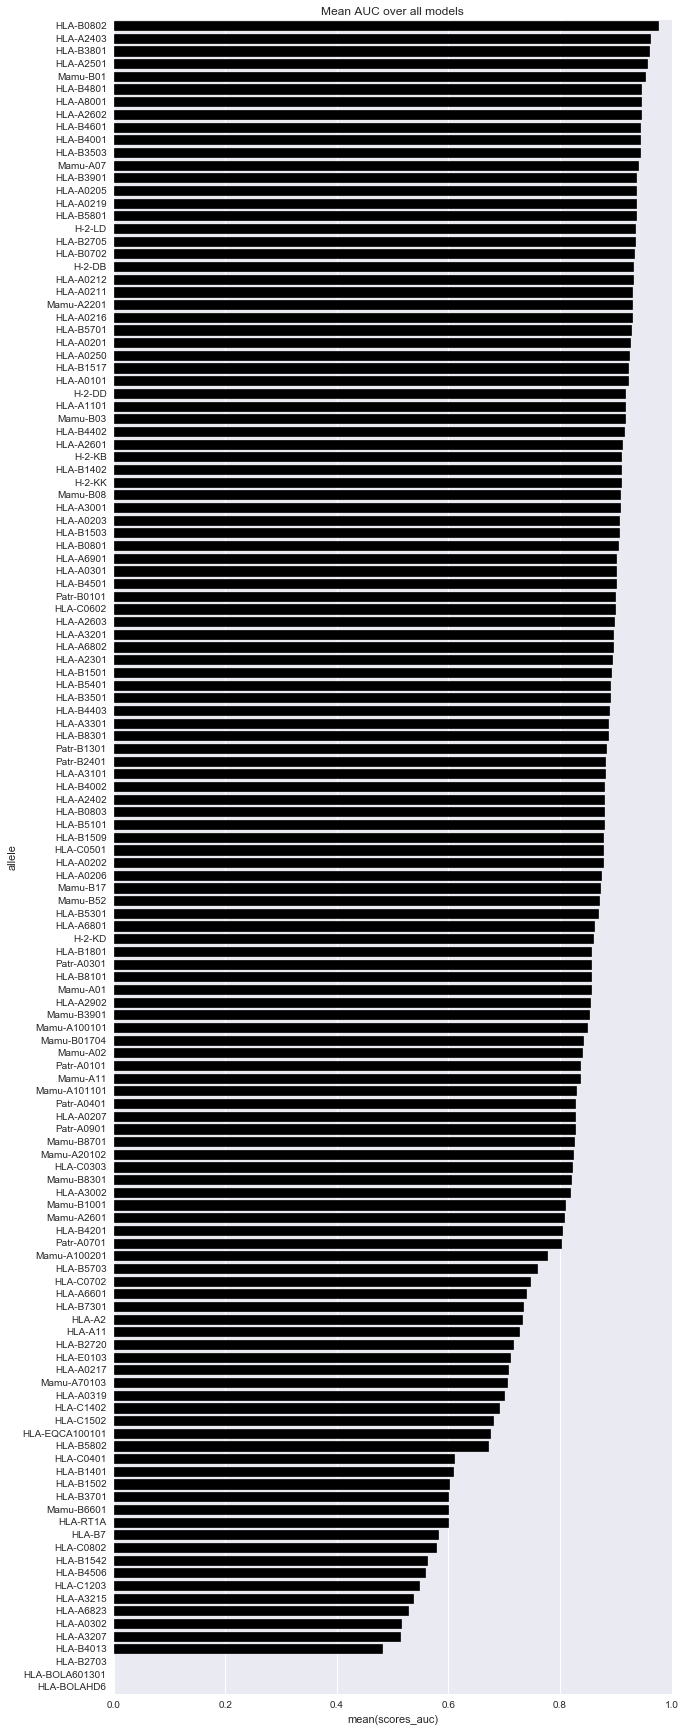

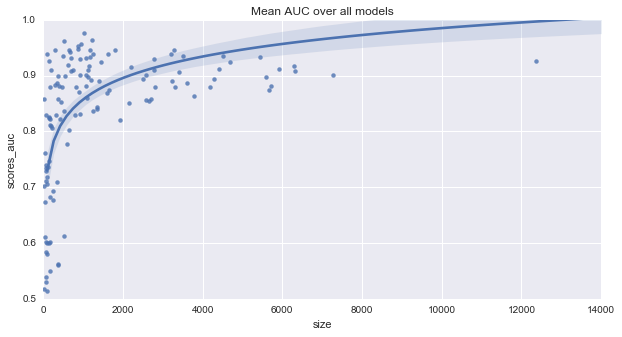

In [63]:
scores = all_models_df.groupby("allele").scores_auc.mean().to_frame().reset_index().sort_values("scores_auc", ascending=False)
scores["size"] = training_sizes.ix[scores.allele].values

pyplot.figure(figsize=(10, 30))
pyplot.title("Mean AUC over all models")
seaborn.barplot(y="allele", x="scores_auc", data=scores, orient="h", color="black")

pyplot.figure(figsize=(10, 5))
pyplot.title("Mean AUC over all models")
seaborn.regplot(x="size", y="scores_auc", data=scores, logx=True)
pyplot.xlim(xmin=0)
pyplot.ylim(ymin=0.5, ymax=1.0)


(0.5, 1)

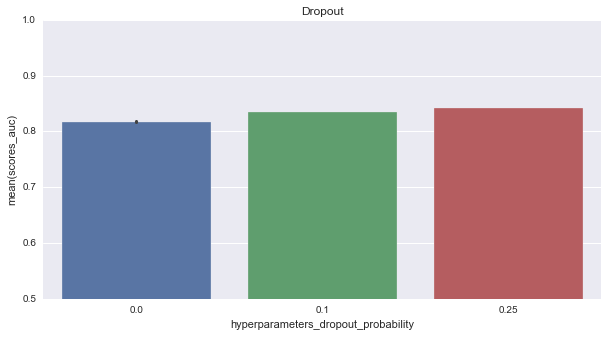

In [8]:
scores = all_models_df.groupby("hyperparameters_dropout_probability").scores_auc.mean().to_frame().reset_index().sort_values("scores_auc", ascending=False)

pyplot.figure(figsize=(10, 5))
pyplot.title("Dropout")
ax = seaborn.barplot(x="hyperparameters_dropout_probability", y="scores_auc", data=all_models_df)
pyplot.ylim(ymin=0.5, ymax=1)

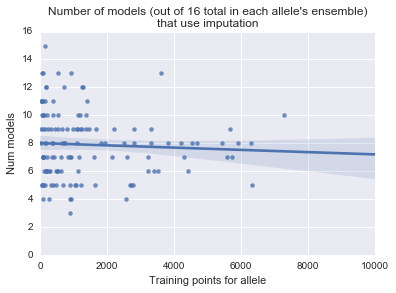

In [12]:
count_impute = selected_models_df.groupby("allele").hyperparameters_impute.sum()

seaborn.regplot(training_sizes.ix[alleles], count_impute.ix[alleles])
pyplot.xlim(xmin=0, xmax=10000)
pyplot.ylim(ymin=0, ymax=16)
pyplot.title("Number of models (out of 16 total in each allele's ensemble)\nthat use imputation")
pyplot.xlabel("Training points for allele")
pyplot.ylabel("Num models")

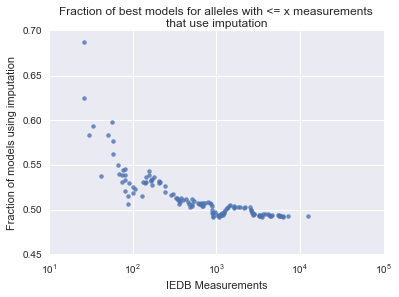

In [13]:
impute_cums_df = selected_models_df.groupby("allele").hyperparameters_impute.mean().to_frame()
impute_cums_df["size"] = training_sizes
impute_cums_df = impute_cums_df.sort_values("size")
impute_cums_df["cum_mean"] = (
    impute_cums_df.hyperparameters_impute.cumsum() / (numpy.arange(len(impute_cums_df)) + 1))
impute_cums_df
seaborn.regplot("size", "cum_mean", data=impute_cums_df, fit_reg=False, logx=True)
pyplot.xscale("log")
pyplot.xlabel("IEDB Measurements")
pyplot.ylabel("Fraction of models using imputation")
pyplot.title(
    "Fraction of best models for alleles with <= x measurements\n"
    "that use imputation")

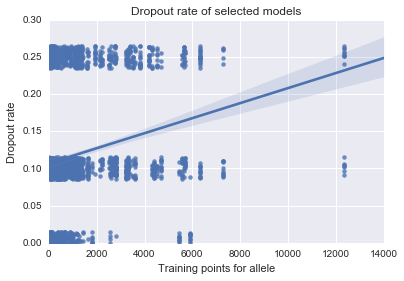

In [14]:
seaborn.regplot(
    selected_models_df.train_size.values,
    selected_models_df.hyperparameters_dropout_probability.values,
    x_jitter=.015,
    y_jitter=.015)
pyplot.xlim(xmin=0)
pyplot.ylim(ymin=0)
pyplot.title("Dropout rate of selected models")
pyplot.xlabel("Training points for allele")
pyplot.ylabel("Dropout rate")

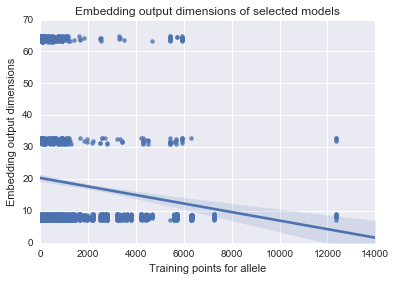

In [15]:
seaborn.regplot(
    selected_models_df.train_size.values,
    selected_models_df.hyperparameters_embedding_output_dim.values,
    x_jitter=1,
    y_jitter=1)
pyplot.xlim(xmin=0)
pyplot.ylim(ymin=0)
pyplot.title("Embedding output dimensions of selected models")
pyplot.xlabel("Training points for allele")
pyplot.ylabel("Embedding output dimensions")

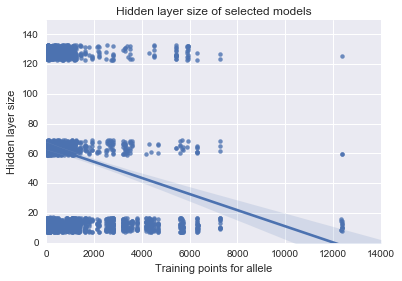

In [16]:
seaborn.regplot(
    selected_models_df.train_size.values,
    selected_models_df.hyperparameters_layer_sizes.map(lambda x: x[0]).values,
    x_jitter=5,
    y_jitter=5)
pyplot.xlim(xmin=0)
pyplot.ylim(ymin=0)
pyplot.title("Hidden layer size of selected models")
pyplot.xlabel("Training points for allele")
pyplot.ylabel("Hidden layer size")

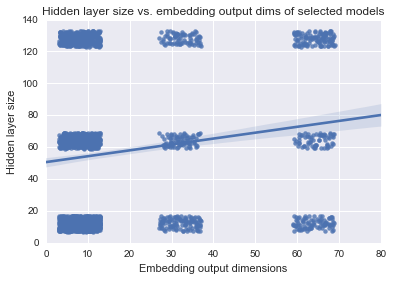

In [17]:
seaborn.regplot(
    selected_models_df.hyperparameters_embedding_output_dim.values,
    selected_models_df.hyperparameters_layer_sizes.map(lambda x: x[0]).values,
    x_jitter=5,
    y_jitter=5)
pyplot.xlim(xmin=0)
pyplot.ylim(ymin=0)
pyplot.title("Hidden layer size vs. embedding output dims of selected models")
pyplot.xlabel("Embedding output dimensions")
pyplot.ylabel("Hidden layer size")

In [101]:
log_path = get_path("models_class1_allele_specific_ensemble", "GENERATE.sh")
with open(log_path) as fd:
    di.display_html("<h1>Model selection invocation</h1><pre>%s</pre>" % fd.read(), raw=True)


Model selection invocation #!/bin/bash

if [[ $# -eq 0 ]] ; then
 echo 'WARNING: This script is intended to be called with additional arguments to pass to mhcflurry-class1-allele-specific-cv-and-train'
 echo 'See README.md'
fi

set -e
set -x

DOWNLOAD_NAME=models_class1_allele_specific_ensemble
SCRATCH_DIR=/tmp/mhcflurry-downloads-generation
SCRIPT_ABSOLUTE_PATH="$(cd "$(dirname "${BASH_SOURCE[0]}")" && pwd)/$(basename "${BASH_SOURCE[0]}")"
SCRIPT_DIR=$(dirname "$SCRIPT_ABSOLUTE_PATH")
export PYTHONUNBUFFERED=1

mkdir -p "$SCRATCH_DIR"
rm -rf "$SCRATCH_DIR/$DOWNLOAD_NAME"
mkdir "$SCRATCH_DIR/$DOWNLOAD_NAME"

# Send stdout and stderr to a logfile included with the archive.
exec > >(tee -ia "$SCRATCH_DIR/$DOWNLOAD_NAME/LOG.txt")
exec 2> >(tee -ia "$SCRATCH_DIR/$DOWNLOAD_NAME/LOG.txt" >&2)

# Log some environment info
date
pip freeze
git rev-parse HEAD
git status

cd $SCRATCH_DIR/$DOWNLOAD_NAME

mkdir models

cp $SCRIPT_DIR/models.py .
python models.py > models.json

time mhcflurry-class1-allele-specific-ensemble-train \
 --ensemble-size 16 \
 --model-architectures models.json \
 --train-data "$(mhcflurry-downloads path data_combined_iedb_kim2014)/combined_human_class1_dataset.csv" \
 --min-samples-per-allele 20 \
 --out-manifest selected_models.csv \
 --out-model-selection-manifest all_models.csv \
 --out-models models \
 --verbose \
 "$@"

bzip2 all_models.csv
cp $SCRIPT_ABSOLUTE_PATH .
tar -cjf "../${DOWNLOAD_NAME}.tar.bz2" *

echo "Created archive: $SCRATCH_DIR/$DOWNLOAD_NAME.tar.bz2"

In [102]:
log_path = get_path("models_class1_allele_specific_ensemble", "LOG.txt")
with open(log_path) as fd:
    lines = fd.readlines(100000)
    di.display_html("<h1>Model selection log (beginning)</h1><pre>%s</pre>" % "".join(lines), raw=True)


Model selection log (beginning) + date
Thu Mar 16 13:18:34 UTC 2017
+ pip freeze
alabaster==0.7.9
anaconda-clean==1.0
anaconda-client==1.5.1
anaconda-navigator==1.3.1
appdirs==1.4.0
argcomplete==1.0.0
astroid==1.4.7
astropy==1.2.1
Babel==2.3.4
backports.shutil-get-terminal-size==1.0.0
beautifulsoup4==4.5.1
biopython==1.68
bitarray==0.8.1
blaze==0.10.1
bokeh==0.12.2
boto==2.42.0
bottle==0.12.13
Bottleneck==1.1.0
cffi==1.7.0
chest==0.2.3
click==6.6
climate==0.4.6
cloudpickle==0.2.1
clyent==1.2.2
colorama==0.3.7
conda==4.2.9
conda-build==2.0.2
configobj==5.0.6
contextlib2==0.5.3
cryptography==1.5
CVXcanon==0.1.1
cvxpy==0.4.8
cycler==0.10.0
Cython==0.24.1
cytoolz==0.8.0
dask==0.11.0
datacache==0.4.20
datashape==0.5.2
decorator==4.0.10
dill==0.2.5
docutils==0.12
downhill==0.4.0
dynd==0.7.3.dev1
ecos==2.0.4
et-xmlfile==1.0.1
fancyimpute==0.1.0
fastcache==1.0.2
filelock==2.0.6
Flask==0.11.1
Flask-Cors==2.1.2
gevent==1.1.2
google-api-python-client==1.5.5
greenlet==0.4.10
gtfparse==0.0.6
h5py==2.6.0
HeapDict==1.0.0
httplib2==0.9.2
humanize==0.5.1
idna==2.1
imagesize==0.7.1
ipdb==0.10.2
ipykernel==4.5.0
ipython==5.1.0
ipython-genutils==0.1.0
ipywidgets==5.2.2
itsdangerous==0.24
jdcal==1.2
jedi==0.9.0
Jinja2==2.8
joblib==0.10.3
jsonschema==2.5.1
jupyter==1.0.0
jupyter-client==4.4.0
jupyter-console==5.0.0
jupyter-core==4.2.0
Keras==1.2.0
knnimpute==0.0.1
-e git+git@github.com:hammerlab/kubeface.git@91fa80a571b9f870c4ec945b834a97fdf863fbc7#egg=kubeface
lazy-object-proxy==1.2.1
llvmlite==0.13.0
locket==0.2.0
lxml==3.6.4
MarkupSafe==0.23
matplotlib==1.5.3
memoized-property==1.0.3
-e git+git@github.com:hammerlab/mhcflurry.git@2925ce8d6c08e8ac0170504b06f1be384a0fc169#egg=mhcflurry
mhcnames==0.1.0
mhctools==0.4.1
mistune==0.7.3
mock==2.0.0
mpmath==0.19
multipledispatch==0.4.8
multiprocess==0.70.4
nb-anacondacloud==1.2.0
nb-conda==2.0.0
nb-conda-kernels==2.0.0
nbconvert==4.2.0
nbformat==4.1.0
nbpresent==3.0.2
-e git+git@github.com:hammerlab/neon.git@f343737d19e1b9509137bf63b9d291d2d8c8bcaf#egg=neon
networkx==1.11
nltk==3.2.1
nose==1.3.7
notebook==4.2.3
numba==0.28.1
numexpr==2.6.1
numpy==1.11.1
oauth2client==4.0.0
odo==0.5.0
openpyxl==2.3.2
pandas==0.18.1
parse==1.6.6
partd==0.3.6
path.py==0.0.0
pathlib2==2.1.0
patsy==0.4.1
pbr==1.10.0
pep8==1.7.0
pepdata==0.7.0
pexpect==4.0.1
pickleshare==0.7.4
Pillow==3.3.1
pkginfo==1.3.2
plac==0.9.6
ply==3.9
progressbar33==2.4
prompt-toolkit==1.0.3
psutil==4.3.1
ptyprocess==0.5.1
py==1.4.31
pyasn1==0.1.9
pyasn1-modules==0.0.8
pycosat==0.6.1
pycparser==2.14
pycrypto==2.6.1
pycurl==7.43.0
pyensembl==1.0.3
pyflakes==1.3.0
Pygments==2.1.3
pylint==1.5.4
pyopen==0.0.6
pyOpenSSL==16.0.0
pyparsing==2.1.4
pytest==2.9.2
python-dateutil==2.5.3
pytz==2016.6.1
PyVCF==0.6.8
PyYAML==3.12
pyzmq==15.4.0
QtAwesome==0.3.3
qtconsole==4.2.1
QtPy==1.1.2
redis==2.10.5
requests==2.11.1
rope-py3k==0.9.4.post1
rsa==3.4.2
ruamel-yaml===-VERSION
scikit-image==0.12.3
scikit-learn==0.18.1
scipy==0.18.1
scs==1.2.6
seaborn==0.7.1
sercol==0.0.2
serializable==0.1.1
simplegeneric==0.8.1
simplejson==3.10.0
singledispatch==3.4.0.3
six==1.10.0
sklearn==0.0
snowballstemmer==1.2.1
sockjs-tornado==1.0.3
Sphinx==1.4.6
spyder==3.0.0
SQLAlchemy==1.0.13
statsmodels==0.6.1
sympy==1.0
tables==3.2.3.1
terminado==0.6
Theano==0.8.2
tinytimer==0.0.0
toolz==0.8.0
tornado==4.4.1
traitlets==4.3.0
typechecks==0.0.2
unicodecsv==0.14.1
uritemplate==3.0.0
varcode==0.5.11
wcwidth==0.1.7
Werkzeug==0.11.11
widgetsnbextension==1.2.6
wrapt==1.10.6
xlrd==1.0.0
XlsxWriter==0.9.3
xlwt==1.1.2
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
+ git rev-parse HEAD
2925ce8d6c08e8ac0170504b06f1be384a0fc169
+ git status
On branch add-class1-ensemble
Your branch is up-to-date with 'origin/add-class1-ensemble'.
nothing to commit, working directory clean
+ cd /tmp/mhcflurry-downloads-generation/models_class1_allele_specific_ensemble
+ mkdir models
+ cp /home/tim/sinai/git/mhcflurry/download